In [2]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.get_device_name())

True
NVIDIA GeForce GTX 1660


In [1]:
#adjusting environment setting
bin_w = 6
bin_h = 10
input_per_bin = 12
epochs = 10000



In [3]:
#model initial
import numpy as np
import torch
from collections import deque
from IPython.display import clear_output
import random
from matplotlib import pylab as plt
import copy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

linear_input = ((((((bin_w*20-8)//2)-2)//2)-2)//2 -2 )*( (((((bin_h*20*2-8)//2)-2)//2)-2)//2 -2 )
action_space = bin_w * bin_h +1

model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 16, kernel_size=5, stride=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(16, 32, kernel_size=5, stride=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2, 2), stride=(2,2)),
    
    torch.nn.Conv2d(32, 16, kernel_size=3, stride=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2, 2), stride=(2,2)),
    
    torch.nn.Conv2d(16, 16, kernel_size=3, stride=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2, 2), stride=(2,2)),

    torch.nn.Conv2d(16, 1, kernel_size=3, stride=1),
    torch.nn.ReLU(),
    #torch.nn.MaxPool2d((2, 2), stride=(2,2)),

    torch.nn.Flatten(),
    #torch.nn.ReLU(),
    torch.nn.Linear(linear_input,64),
    #torch.nn.ReLU(),
    torch.nn.Linear(64,action_space)
)

model = model.to(device)
model2 = copy.deepcopy(model).to(device)#A
model2.load_state_dict(model.state_dict()) #B

loss_fn = torch.nn.MSELoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.95
epsilon = 1


losses = []
rewards = []
mem_size = 20000
batch_size = 32
replay = deque(maxlen=mem_size)
sync_freq = 500  #每500次將eval model 複製到target model


In [4]:
# target model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# target model



import os
import time
#delete output file last time
try:
    os.remove("time.txt")
    os.remove("train_state_action.txt")
    os.remove("action_reward_T.txt")    
    os.remove("reward_result_T.txt")
    os.remove("action_reward_T.txt")
    os.remove("qval_result_T.txt")
    os.remove("valid_place_T.txt")
    os.remove("show_tree.txt")
    os.remove("show_tree_test.txt")
    os.remove("train_state_D_bin.txt")
    
except OSError as e:
    print(e)
else:
    print("File is deleted successfully")


#get all slice info
#get all slice info
file = open("slice data/610_12item.txt",'r')
content = file.read()
file.close
slices = content.split('\n')
print(slices)


#training setting
h = 0
#initial state
input_count = 0
shape = (bin_w,bin_h*2,)
#6*10 bin, 0 = empty, 1 = filled
tree_tensor = torch.zeros(shape)
state1_ = tree_tensor.reshape(1,bin_w*bin_h*2) 
time0 = time.time()

j=0         #計算500次內的第幾次

total_accept = 0 #total item accepted numbers in all episodes 
total_area = 0  #total area count of "1" episode
accept_prob_per_board = [] #store accept rate of each episode
PE_per_baord = [] #store PE of each episode
action_count = [0] * (bin_w*bin_h+1) #calculate all action using numbers 
for i in range(epochs):    
    #clear board and generate a full bin to train
    #generated_string = generate_full_bin()
    #slices = generated_string.split('\n')

    tree_tensor = torch.zeros(shape)
    state1_ = tree_tensor.reshape(1,bin_w*bin_h*2) #initial new tensor for this episode
    random.shuffle(slices) 
    status = 1  #1:all item of this episode input yet, will be 0 after all input 
    input_count = 0 # calculate input item's number of this episode
    accepted_count = 0 # accept numbers of this episode
    total_area = 0 #sum of area of accept item
    while(status == 1): #1 1:all item of this episode input yet, will be 0 after all input and leave this wile loop
      #set state        
      #new_slice = slices[(i%800)*12 + input_count].split()
      time1 = time.time() 
      with open("time.txt",'a') as f:
        f.write("episode:")
        f.write(str(i))
        f.write("\n")
      new_slice = slices[input_count].split() # get "width height" information, split by " " into ["width","height"]
      width = new_slice[0]
      height = new_slice[1]
      width_ = float(width) / 100
      height_ = float(height) / 100
      width = int(width_)
      height = int(height_)
      #input slice
      #deploy input item into another side of bin in tensor
      for index in range(bin_w*bin_h,bin_w*bin_h*2): #clear second half of bin
        state1_[0,index] = 0
      
      for y in range(height):
        for x in range(width):
          state1_[0,(bin_w*bin_h*2)- bin_w + x - (bin_w*y)] = 1
        
      #show new item and state
      with open("train_state_action.txt", 'a') as f:
        f.write("episode:")
        f.write(str(i+1))
        f.write("step:")
        f.write(str(input_count+1))
        f.write("\n")
      with open("train_state_action.txt", 'a') as f:
        f.write("new:\n")
      for y in range(bin_h*2 -1 ,-1,-1):
          if y == bin_h -1 :
            with open("train_state_action.txt", 'a') as f:
              f.write("bin:\n")
          for x in range(bin_w):
            with open("train_state_action.txt", 'a') as f:
              if state1_[0,x+bin_w*y] < 1:
                f.write("0")
              else:
                f.write("1")
          with open("train_state_action.txt", 'a') as f:
            f.write("\n")

      input_count += 1 
           
      j+=1  #for counting when to sync, sync every 500
      #convert tensor to image to input to CNN
      img = state1_.reshape(bin_h*2 ,-1)
      img_big = torch.zeros(bin_h*2*20,bin_w*20)
      for y in range(bin_w):  #x row, y column
        for x in range(bin_h*2):
          if img[x,y] == 1:
            for a in range(20):
              for b in range(20):
                img_big[x*20+a,y*20+b] = 1
      """      
      if i < 1:
        plt.imshow(img_big,cmap='gray')  
        path = "state img/episode_" + str(i+1) +" step_"+str(input_count) + ".png"
        plt.savefig(path)
      """
      img_big = img_big.expand(1,bin_h*2*20,bin_w*20)
      time2 = time.time()
      with open("time.txt",'a') as f:
        f.write("get state:")
        f.write(str(time2-time1))
        f.write("\n")
              
      #print(img_big.size())  
      #generate Q value
      qval = model(img_big.float().to(device))
      qval_ = qval.data.cpu().numpy()
      
      
      time3 = time.time()
      with open("time.txt",'a') as f:
        f.write("CNN_DQN:")
        f.write(str(time3-time2))
        f.write("\n")
      #store state before action
      temp_state1_ = state1_
     
      #select action

      if (random.random() < epsilon):
        #R random choose one 
        action_ = np.random.randint(0,action_space)
        with open("train_state_action.txt", 'a') as f:
            f.write("R:")    
      else:
        #Q:choose max Q
        action_ = np.argmax(qval_)
        with open("train_state_action.txt", 'a') as f:
            f.write("Q:")  

      action_count[action_] += 1 #calculate each action's using times
      
      with open("train_state_action.txt", 'a') as f:
            f.write(str(action_))
            f.write("\t")   

      #check need deploy?  
      if action_ != bin_w * bin_h : # no action
        #check unvalid 1.out of range 2.overlap
        check_unvalid = 0
        action_column = action_ % bin_w
        if width + action_column -1 > bin_w-1: #out of right range
          check_unvalid = 1
          
        for y in range(height): #out of top range
          for x in range(width):     
            if action_+x+bin_w*y > bin_w * bin_h -1:
              check_unvalid = 1

        if check_unvalid == 0:
          for y in range(height):
            for x in range(width):
              if state1_[0,action_+x+bin_w*y] == 1:   # 2.overlap
                check_unvalid = 1

        #deploy
        if check_unvalid != 1:
          accepted_count += 1
          total_accept += 1
          total_area += width * height
          #deploy
          for y in range(height):
            for x in range(width):
              state1_[0,action_+x+bin_w*y] = 1 
              
          
        reward = 0
        #calculate reward
        if check_unvalid != 1: #Ok
          check = 0
          cluster_Q = []
          cluster_Q.append(action_)
          #print(cluster_Q)
          while check < len(cluster_Q):
            if cluster_Q[check] - 1 > -1 and cluster_Q[check] - 1 not in cluster_Q: #left
              if state1_[0,cluster_Q[check] - 1] == 1:
                cluster_Q.append(cluster_Q[check] - 1)
            if cluster_Q[check] % bin_w + 1 < bin_w and cluster_Q[check] + 1 not in cluster_Q: #right
              if state1_[0,cluster_Q[check] + 1] == 1:
                cluster_Q.append(cluster_Q[check] + 1)
            if cluster_Q[check] - bin_w > -1 and cluster_Q[check] - bin_w not in cluster_Q: #down 
              if state1_[0,cluster_Q[check] - bin_w] == 1:
                cluster_Q.append(cluster_Q[check] - bin_w)  
            if cluster_Q[check] + bin_w < bin_w * bin_h and cluster_Q[check] + bin_w not in cluster_Q: #up
              if state1_[0,cluster_Q[check] + bin_w] == 1:
                cluster_Q.append(cluster_Q[check] + bin_w)
            check += 1

          #print(cluster_Q,"size = ",len(cluster_Q))
          min_x = 999
          max_x = -1
          min_y = 999
          max_y = -1
          for check in cluster_Q:
            #print("check:",check)
            #get edge of rectangle which can surrond this cluster by using minimal size
            this_y = check // bin_w
            this_x = check % bin_w
            if this_x < min_x:
              min_x = this_x
            if this_x > max_x:
              max_x = this_x
            if this_y < min_y:
              min_y = this_y
            if this_y > max_y:
              max_y = this_y

          #print("x:",min_x,max_x," y:",min_y,max_y)
          compactness = len(cluster_Q) / ((max_x - min_x + 1) * (max_y - min_y + 1))
          #print(compactness)
          reward = len(cluster_Q)*compactness
        else:
          reward = -80
      else: #action is 25 no action, calculate special reward
        reward = -50
        """
        reward_for_25 = []
        for start in range(24):
          if state1_[0,start] == 1:
            check = 0
            cluster_Q = []
            cluster_Q.append(start)
            #print(cluster_Q)
            while check < len(cluster_Q):
              if cluster_Q[check] - 1 > -1 and cluster_Q[check] - 1 not in cluster_Q: #left
                if state1_[0,cluster_Q[check] - 1] == 1:
                  cluster_Q.append(cluster_Q[check] - 1)
              if cluster_Q[check] + 1 < 25 and cluster_Q[check] + 1 not in cluster_Q: #right
                if state1_[0,cluster_Q[check] + 1] == 1:
                  cluster_Q.append(cluster_Q[check] + 1)
              if cluster_Q[check] - 5 > -1 and cluster_Q[check] - 5 not in cluster_Q: #down 
                if state1_[0,cluster_Q[check] - 5] == 1:
                  cluster_Q.append(cluster_Q[check] - 5)  
              if cluster_Q[check] + 5 < 25 and cluster_Q[check] + 5 not in cluster_Q: #up
                if state1_[0,cluster_Q[check] + 5] == 1:
                  cluster_Q.append(cluster_Q[check] + 5)
              check += 1

              #print(cluster_Q,"size = ",len(cluster_Q))
            min_x = 999
            max_x = -1
            min_y = 999
            max_y = -1
            for check in cluster_Q:
              #print("check:",check)
              this_y = check // 5
              this_x = check % 5
              if this_x < min_x:
                min_x = this_x
              if this_x > max_x:
                max_x = this_x
              if this_y < min_y:
                min_y = this_y
              if this_y > max_y:
                max_y = this_y

            #print("x:",min_x,max_x," y:",min_y,max_y)
            compactness = len(cluster_Q) / ((max_x - min_x + 1) * (max_y - min_y + 1))
            reward_for_25.append(len(cluster_Q)*compactness)
        if len(reward_for_25):
          reward =  max(reward_for_25)
        else:
          reward = 0
        """
      time4 = time.time()
      with open("time.txt",'a') as f:
        f.write("choose action, deploy and reward:")
        f.write(str(time4-time3))
        f.write("\n")
        
      if input_count == input_per_bin:  #reward at last step K*PE, K = 2
        reward += 2*(total_area / bin_w * bin_h)
        
      with open("train_state_action.txt", 'a') as f:
            f.write("reward:")
            f.write(str(reward))
            f.write("\n")   
      #print("reward=",reward)
      rewards.append(reward)
      with open("train_state_action.txt", 'a') as f:
            f.write("Q value:\n")
            f.write(str(qval_))
            f.write("\n\n")  

      state2_ = state1_ #state2_ is s' of (s,a,r,s') in replay buffer
      state1_ = temp_state1_ #state1_ is s, temp is store before take an action
      done = True if input_count == input_per_bin else False
      
      #get next input  
      for index in range(bin_w*bin_h,bin_w*bin_h*2): #clear second half of 
        state2_[0,index] = 0

      if input_count < input_per_bin:
        next_slice = slices[input_count].split() # get "width height" information, split by " " into ["width","height"]
        width = next_slice[0]
        height = next_slice[1]
        width_ = float(width) / 100
        height_ = float(height) / 100
        width = int(width_)
        height = int(height_)
              
        for y in range(height):
          for x in range(width):
            state2_[0,(bin_w*bin_h*2)- bin_w + x - (bin_w*y)] = 1

      img_state2 = state2_.reshape(bin_h * 2,-1)
      img_state2_big = torch.zeros(bin_h * 20 * 2,bin_w * 20)
      for y in range(bin_w):
        for x in range(bin_h * 2):
          if img_state2[x,y] == 1:
            for a in range(20):
              for b in range(20):
                img_state2_big[x*20+a,y*20+b] = 1

      img_state2_big = img_state2_big.expand(1,bin_h * 20 * 2,bin_w * 20)

      exp =  (img_big, action_, reward, img_state2_big,done)
      replay.append(exp) #H
      time5 = time.time()
      with open("time.txt",'a') as f:
        f.write("save to replay:")
        f.write(str(time5-time4))
        f.write("\n")
        
      if input_count == input_per_bin:
        accept_prob_per_board.append(accepted_count/input_per_bin)
        PE_per_baord.append(total_area / (bin_w * bin_h))
        status = 0 #one board done, exit while and clear board

      state1_ = state2_
    
      if len(replay) > batch_size:
        start_train_time = time.time()
        minibatch = random.sample(replay, batch_size)
        state1_batch = torch.stack([s1 for (s1,a,r,s2,d) in minibatch]).to(device)
        action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch]).to(device)
        reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch]).to(device)
        state2_batch = torch.stack([s2 for (s1,a,r,s2,d) in minibatch]).to(device)
        done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch]).to(device)

        # double dqn
        Q1 = model(state1_batch.float()).to(device)
        Q2_action = model(state2_batch.float()).to(device)
        target_index = torch.max(Q2_action,dim=1)[1] #eval model choose action
        with torch.no_grad():
            Q2 = model2(state2_batch.float()).to(device) #target model calculate q-value
        
        Y = reward_batch + gamma * (1-done_batch) * Q2.gather(dim=1,index=target_index.long().unsqueeze(dim=1)).squeeze()
        X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
        """
        Q1 = model(state1_batch.float()).to(device) 
        with torch.no_grad():
            Q2 = model2(state2_batch.float()).to(device) #B
        
        Y = reward_batch + gamma * ((1-done_batch) * torch.max(Q2,dim=1)[0])
        X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
        """
        loss = loss_fn(X, Y.detach())
        #if i % 100 == 0:
        print(i,"/",epochs, loss.item())
        clear_output(wait=True)
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        end_train_time = time.time()
        with open("time.txt",'a') as f:
          f.write("train:")
          f.write(str(end_train_time-start_train_time))
          f.write("\n")    
        if j % sync_freq == 0: #C
            model2.load_state_dict(model.state_dict())

    if epsilon > 0.001: #epsilon decrease linearly
      epsilon -= (1/epochs)
time_finish = time.time()
with open("time.txt",'a') as f:
        f.write("\n\n\ntime for")
        f.write(str(epochs))
        f.write(" : ")
        f.write(str(time_finish-time0))
        f.write("\n")
losses = np.array(losses)
print(epochs,"episodes ends in: ",time_finish-time0," secs")
print("all action take times:\n",action_count)

#A Set the update frequency for synchronizing the target model parameters to the main DQN
#B Use the target network to get the maiximum Q-value for the next state
#C Copy the main model parameters to the target network

10000 episodes ends in:  36052.42978835106  secs
all action take times:
 [2343, 3033, 1285, 2497, 1314, 1192, 4324, 1462, 1496, 5554, 1167, 1156, 2471, 1565, 1487, 2668, 1041, 1176, 3516, 1725, 1581, 4237, 1298, 1180, 2221, 1067, 1533, 3268, 1299, 1106, 2881, 2270, 1731, 3135, 2820, 1623, 2304, 1344, 1511, 3112, 1069, 1332, 1964, 1078, 1374, 2226, 1015, 1131, 3693, 1424, 1060, 3803, 1048, 983, 2140, 1279, 1080, 2625, 1017, 997, 3669]


# Target network

In [5]:
torch.save(model.state_dict(), "deeppack_dynamic_model_0122.pt")

total accept rate:  0.580225


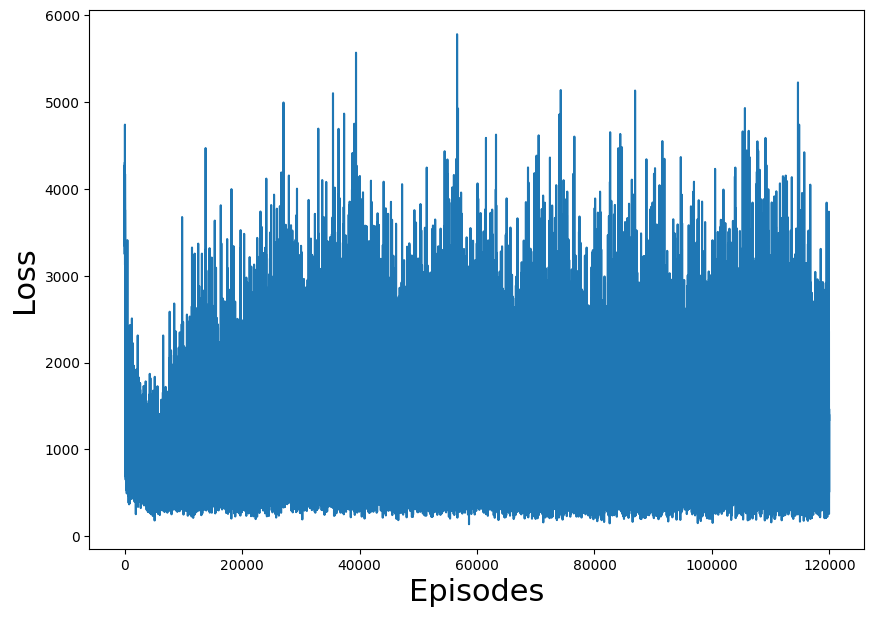

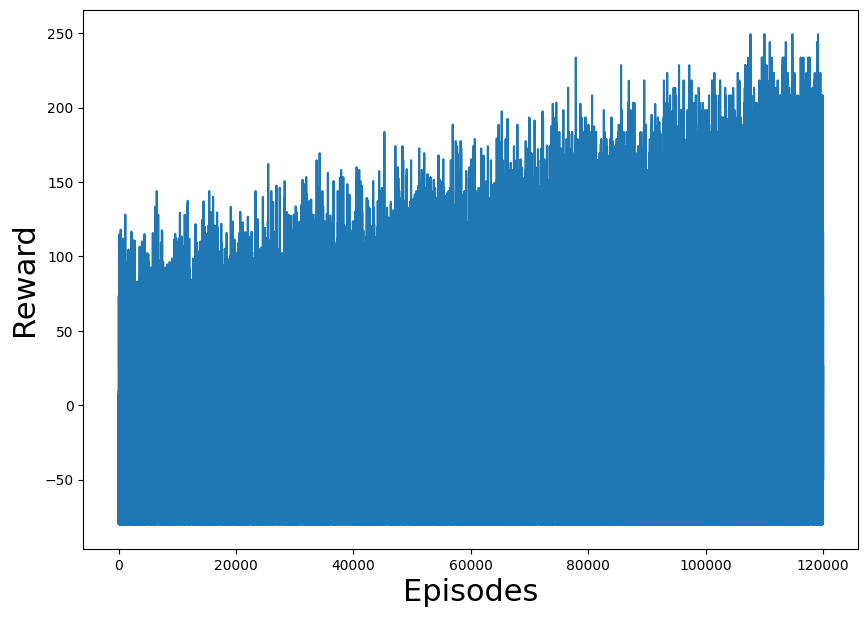

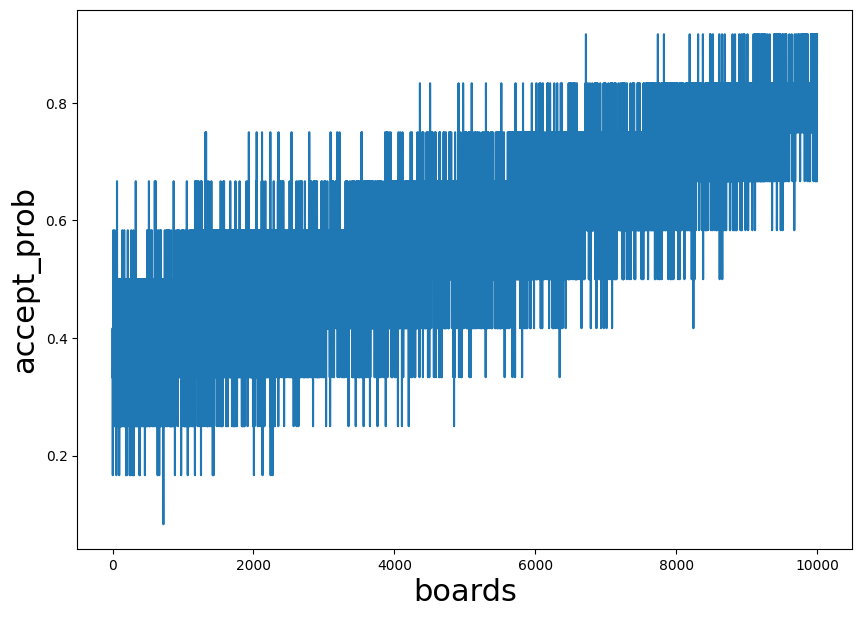

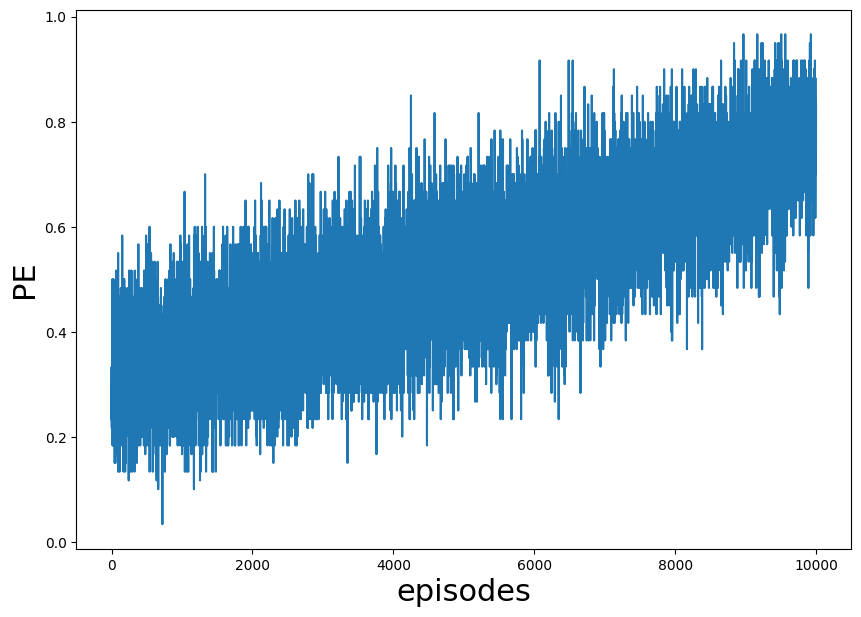

In [6]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Episodes",fontsize=22)
plt.ylabel("Loss",fontsize=22)
plt.savefig("train_loss610.png")

plt.figure(figsize=(10,7))
plt.plot(rewards)
plt.xlabel("Episodes",fontsize=22)
plt.ylabel("Reward",fontsize=22)
plt.savefig("train_reward610.png")

plt.figure(figsize=(10,7))
plt.plot(accept_prob_per_board)
plt.xlabel("boards",fontsize=22)
plt.ylabel("accept_prob",fontsize=22)
plt.savefig("train_accept_prob_per_board610.png")

plt.figure(figsize=(10,7))
plt.plot(PE_per_baord)
plt.xlabel("episodes",fontsize=22)
plt.ylabel("PE",fontsize=22)
plt.savefig("train_PE_per_baord610.png")

print("total accept rate: ",total_accept/(epochs*input_per_bin))

In [9]:
#load model for test
import numpy as np
import torch
from collections import deque
from IPython.display import clear_output
import random
from matplotlib import pylab as plt
import copy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
l1 = 50
l2 = 64
l4 = 26


linear_input = ((((((bin_w*20-8)//2)-2)//2)-2)//2 -2 )*( (((((bin_h*20*2-8)//2)-2)//2)-2)//2 -2 )
action_space = bin_w * bin_h +1

model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 16, kernel_size=5, stride=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(16, 32, kernel_size=5, stride=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2, 2), stride=(2,2)),
    
    torch.nn.Conv2d(32, 16, kernel_size=3, stride=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2, 2), stride=(2,2)),
    
    torch.nn.Conv2d(16, 16, kernel_size=3, stride=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2, 2), stride=(2,2)),

    torch.nn.Conv2d(16, 1, kernel_size=3, stride=1),
    torch.nn.ReLU(),
    #torch.nn.MaxPool2d((2, 2), stride=(2,2)),

    torch.nn.Flatten(),
    #torch.nn.ReLU(),
    torch.nn.Linear(linear_input,64),
    #torch.nn.ReLU(),
    torch.nn.Linear(64,action_space)
)
model = model.to(device)
model.load_state_dict(torch.load("deeppack_dynamic_model_0122.pt"))
model.eval()

model2 = copy.deepcopy(model).to(device) 
model2.load_state_dict(model.state_dict()) #B

loss_fn = torch.nn.MSELoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.95
epsilon = 0.001

In [10]:
#model test
from collections import deque
import random
import os
#delete output file last time
try:
    os.remove("test_result_D.txt")
    os.remove("test_result_D_bin.txt")
    os.remove("test_state_D_bin.txt")
    os.remove("show_tree_test.txt")
except OSError as e:
    print(e)
else:
    print("File is deleted successfully")


#get all slice info
file = open("slice data/610_12item.txt",'r')
content = file.read()
file.close
slices = content.split('\n')

#training setting

test_epochs = 100

rewards_test = []

h = 0
#initial state
input_count = 0
shape = (bin_w,bin_h*2,)
#5*5 bin, 0 = empty, 1 = filled
tree_tensor = torch.zeros(shape)
state1_ = tree_tensor.reshape(1,bin_w*bin_h*2)


sync_freq = 500  #每500次將eval model 複製到target model
j=0         #計算500次內的第幾次
#do_clear = 0
tree_count = 0
total_accept = 0
total_area = 0
PE_per_baord_test = []
accept_prob_per_board_test = []
test_state_img = []
test_img = []
for i in range(test_epochs):    
    #if(i%48 == 0):  #clear board
    random.shuffle(slices)
    #do_clear = 0
    shape = (bin_w,bin_h*2,)
    #5*5 bin, 0 = empty, 1 = filled
    tree_tensor = torch.zeros(shape)
    state1_ = tree_tensor.reshape(1,bin_w*bin_h*2)
    status = 1
    input_count = 0
    accepted_count = 0
    total_area = 0
    while(status == 1): #1 board
      #set state        
      new_slice = slices[input_count].split()
      width = new_slice[0]
      height = new_slice[1]
      width_ = float(width) / 100
      height_ = float(height) / 100
      width = int(width_)
      height = int(height_)
      input_count += 1

      #input slice
      #deploy new
      for index in range(bin_w*bin_h,bin_w*bin_h*2):
        state1_[0,index] = 0
      
      for y in range(height):
        for x in range(width):
          state1_[0,bin_w*bin_h*2-bin_w+x-bin_w*y] = 1

      j+=1

      img = state1_.reshape(bin_h*2 ,-1)
      img_big = torch.zeros(bin_h*2*20,bin_w*20)
      for y in range(bin_w):  #x row, y column
        for x in range(bin_h*2):
          if img[x,y] == 1:
            for a in range(20):
              for b in range(20):
                img_big[x*20+a,y*20+b] = 1
                
      test_state_img.append(img_big)
      
      img_big = img_big.expand(1,bin_h*2*20,bin_w*20)
      
      qval = model(img_big.float().to(device))
      qval_ = qval.data.cpu().numpy()

      #select action

      if (random.random() < epsilon):
        #R random choose one in valid place
        action_ = np.random.randint(0,action_space)

      else:
        #Q:choose max Q
        action_ = np.argmax(qval_)
  
      temp_state1_ = state1_

      #check need deploy?  
      if action_ != bin_w * bin_h : # no action
        #check unvalid 1.out of range 2.overlap
        check_unvalid = 0
        action_column = action_ % bin_w
        if width + action_column -1 > bin_w: #out of right range
          check_unvalid = 1
          
        for y in range(height): #out of top range
          for x in range(width):     
            if action_+x+bin_w*y > bin_w * bin_h -1:
              check_unvalid = 1

        if check_unvalid == 0:
          for y in range(height):
            for x in range(width):
              if state1_[0,action_+x+bin_w*y] == 1:   # 2.overlap
                check_unvalid = 1

        #deploy
        if check_unvalid != 1:
          accepted_count += 1
          total_accept += 1
          total_area += width * height
          #deploy
          for y in range(height):
            for x in range(width):
              state1_[0,action_+x+bin_w*y] = 1  
          
        reward = 0
        #calculate reward
        if check_unvalid != 1: #Ok
          check = 0
          cluster_Q = []
          cluster_Q.append(action_)
          #print(cluster_Q)
          while check < len(cluster_Q):
            if cluster_Q[check] - 1 > -1 and cluster_Q[check] - 1 not in cluster_Q: #left
              if state1_[0,cluster_Q[check] - 1] == 1:
                cluster_Q.append(cluster_Q[check] - 1)
            if cluster_Q[check] % bin_w + 1 < bin_w and cluster_Q[check] + 1 not in cluster_Q: #right
              if state1_[0,cluster_Q[check] + 1] == 1:
                cluster_Q.append(cluster_Q[check] + 1)
            if cluster_Q[check] - bin_w > -1 and cluster_Q[check] - bin_w not in cluster_Q: #down 
              if state1_[0,cluster_Q[check] - bin_w] == 1:
                cluster_Q.append(cluster_Q[check] - bin_w)  
            if cluster_Q[check] + bin_w < bin_w * bin_h and cluster_Q[check] + bin_w not in cluster_Q: #up
              if state1_[0,cluster_Q[check] + bin_w] == 1:
                cluster_Q.append(cluster_Q[check] + bin_w)
            check += 1

          #print(cluster_Q,"size = ",len(cluster_Q))
          min_x = 999
          max_x = -1
          min_y = 999
          max_y = -1
          for check in cluster_Q:
            #print("check:",check)
            #get edge of rectangle which can surrond this cluster by using minimal size
            this_y = check // bin_w
            this_x = check % bin_w
            if this_x < min_x:
              min_x = this_x
            if this_x > max_x:
              max_x = this_x
            if this_y < min_y:
              min_y = this_y
            if this_y > max_y:
              max_y = this_y

          #print("x:",min_x,max_x," y:",min_y,max_y)
          compactness = len(cluster_Q) / ((max_x - min_x + 1) * (max_y - min_y + 1))
          #print(compactness)
          reward = len(cluster_Q)*compactness
        else:
          reward = -80
      else: #action is 25 no action, calculate special reward
        reward = -50

      print("reward=",reward)
      rewards_test.append(reward)
      
      state2_ = state1_
      state1_ = temp_state1_

        
      if input_count == input_per_bin:
        accept_prob_per_board_test.append(accepted_count/input_per_bin)
        PE_per_baord_test.append(total_area / (bin_w * bin_h))
        
        finish_img = state1_.reshape(bin_h*2,-1)
        """
        finish_img_big = torch.zeros(100,100)
        for y in range(5):
          for x in range(5):
            if finish_img[x,y] == 1:
              for a in range(20):
                for b in range(20):
                  finish_img_big[x*20+a,y*20+b] = 1
        """

        test_img.append(finish_img)
        
        status = 0 #one board done, exit while and clear board


      

      state1_ = state2_
      print("episode:",i)
      clear_output(wait=True)
    if epsilon > 0.1:
      epsilon -= (1/test_epochs)
        

print("total accept rate: ",total_accept/(100*input_per_bin))


total accept rate:  0.82


total accept rate:  0.82


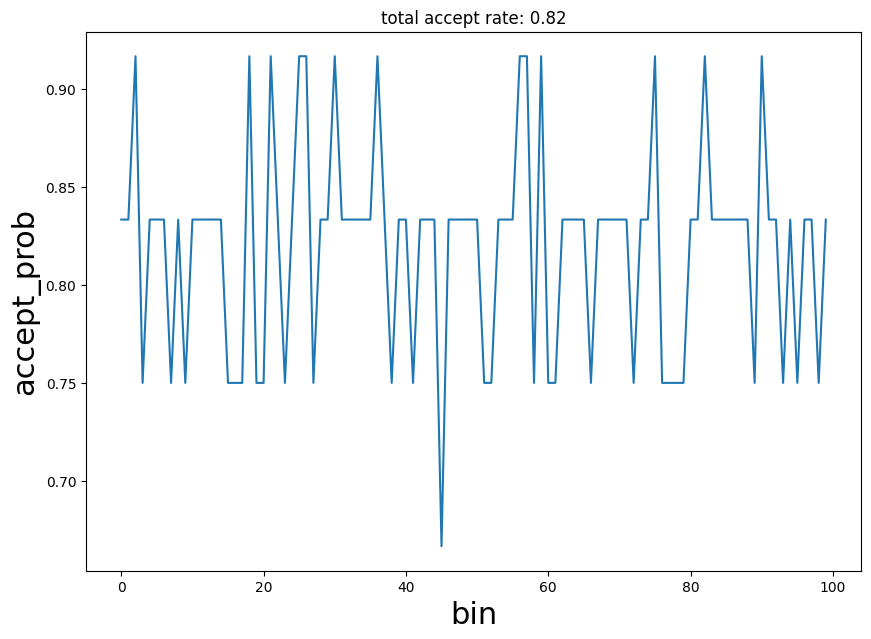

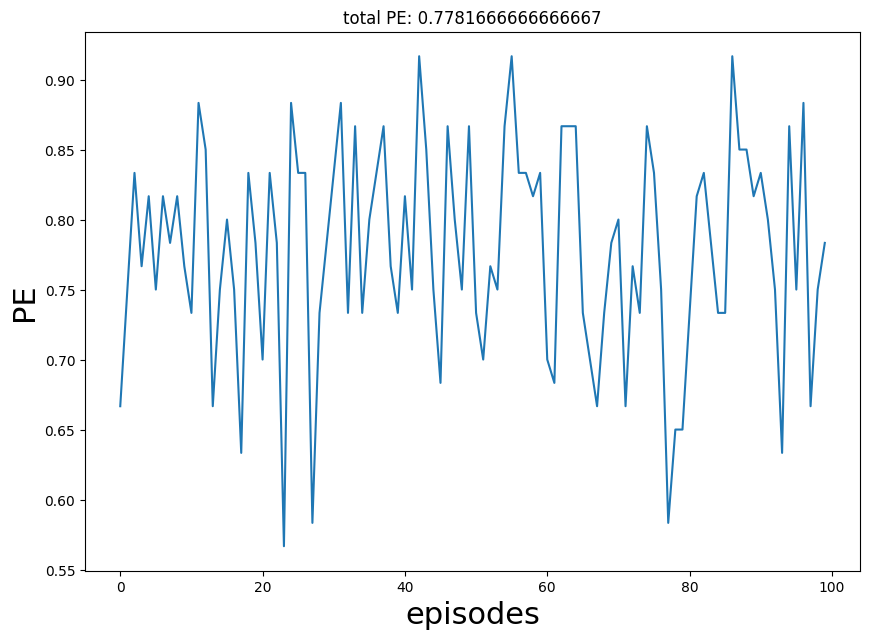

In [11]:
total_accept_rate_string = "total accept rate: " + str(total_accept/(100*input_per_bin))
total_PE_string = "total PE: " + str(sum(PE_per_baord_test)/len(PE_per_baord_test))
plt.figure(figsize=(10,7))
plt.title(total_accept_rate_string)
plt.plot(accept_prob_per_board_test)
plt.xlabel("bin",fontsize=22)
plt.ylabel("accept_prob",fontsize=22)
plt.savefig("accept_prob_per_board_test.png")

plt.figure(figsize=(10,7))
plt.title(total_PE_string)
plt.plot(PE_per_baord_test)
plt.xlabel("episodes",fontsize=22)
plt.ylabel("PE",fontsize=22)
plt.savefig("PE_per_baord_test.png")

print("total accept rate: ",total_accept/(100*input_per_bin))

#for now in range(100):
#  print("time window",now+1,":",round(accept_prob_per_board[now],3),end = ',')
#  if now % 10 == 9:
#    print("\n")

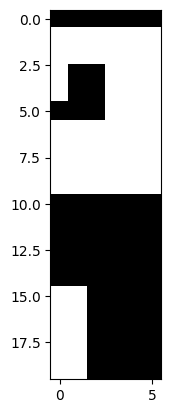

In [12]:
for item in range(len(test_img)):
    plt.imshow(test_img[item],cmap='gray')
    path =   "result img dy/" + str(item+1) + ".png"
    plt.savefig(path)

KeyboardInterrupt: 

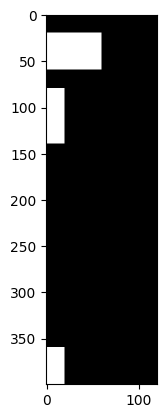

In [22]:

for item in range(len(test_state_img)):
    plt.imshow(test_state_img[item],cmap='gray')
    path =   "result img every step dy/episode_" + str(item//input_per_bin+1) +"_step_"+ str(item%input_per_bin+1) + ".png"
    plt.savefig(path)


rectengular item train

In [103]:
torch.save(model.state_dict(), "deeppack_gpu_model_every_step_rect_0113.pt")